#Heston Model Data prediction using Fourier Neural Operator

The Heston model is a model to evaluate the call price of an option, while assuming volatility to be a stochastic process modeled by the Cox Ingersoll Ross model which doesn't have explicit solutions.

The Fourier Neural Operator model takes an input grid of 2 dimensions with other variables fixed and evaluated the functional relation between the variables to produce results.

It first converts the data into the frequency domain by applying Fourier Transform and then learns the operator relation between the input and the output. Following this it applies inverse transform and produces a grid of the output across the grid of the 2 variables.

In this project we continue with model creation using pytorch and evaluating the model on data generated using the equations.

We first train the model on Black Scholes Merton equation data as it considers volatility as cosntant which forms the base of our model, further we expandby training on the Heston data generated by introducing randomness into the model.

This is the Black scholes equation
$$
\frac{\partial V}{\partial t} + \frac{1}{2} \sigma^2 S^2 \frac{\partial^2 V}{\partial S^2} + r S \frac{\partial V}{\partial S} - r V = 0
$$

This is the Heston Model
$$
dS_t = \mu S_t\, dt + \sqrt{v_t} S_t\, dW_t^S \\
dv_t = \kappa (\theta - v_t)\, dt + \sigma_v \sqrt{v_t}\, dW_t^v
$$
$$
dW_t^S \cdot dW_t^v = \rho\, dt
$$

$$
\frac{\partial V}{\partial t} + \frac{1}{2} v S^2 \frac{\partial^2 V}{\partial S^2}
+ \rho \sigma_v v S \frac{\partial^2 V}{\partial S \partial v}
+ \frac{1}{2} \sigma_v^2 v \frac{\partial^2 V}{\partial v^2}
+ r S \frac{\partial V}{\partial S}
+ \kappa (\theta - v) \frac{\partial V}{\partial v}
- r V = 0
$$

In [31]:
import numpy as np
import torch
import torch.nn as nn
import torch.fft
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [32]:
X_bs = np.load("bs_FNO_in.npy")
y_bs = np.load("bs_FNO_out.npy")
X_heston = np.load("heston_FNO_in.npy")
y_heston = np.load("heston_FNO_out.npy")

print("Input shape bs:", X_bs.shape)
print("Output shape bs:", y_bs.shape)
print("Input shape heston:", X_heston.shape)
print("Output shape heston:", y_heston.shape)

Input shape bs: (100, 16, 16, 9)
Output shape bs: (100, 16, 16, 1)
Input shape heston: (100, 16, 16, 9)
Output shape heston: (100, 16, 16, 1)


# Model

The model is defined using the PyTorch library with FNO2d as the main function and SpectralConv2d as submodule for fourier transformation and evaluation.


*   In channels = number of input variables
*   out channels = number of output variables
*   Width = size of hidden Spectral layers
*   modes1 and modes2 = number of low-frequency modes to keep in each dimension
*   We add skip connection and combine it with spectral to also include rough part of the equation.
*   In the Einsum() function:


  1.   bixy: batch dimensions, Input channels, Freq dim 1, Freq dim 2
  2.   ioxy: Input channels, output channels, freq dim 1, freq dim 2
  3.   boxy: batch dimensions, Output channels, Freq dim 1, Freq dim 2

  Essentially means sum over all input channels for wach batch, output channel, and frequency index.





In [33]:
class SpectralConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, modes1, modes2):
        super().__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.modes1 = modes1
        self.modes2 = modes2
        self.scale = 1 / (in_channels * out_channels)
        self.weights = nn.Parameter(
            self.scale * torch.rand(in_channels, out_channels, modes1, modes2, dtype=torch.cfloat)
        )

    def forward(self, x):
        B, C, H, W = x.shape
        x_ft = torch.fft.rfft2(x)
        modes1 = min(self.modes1, x_ft.shape[-2])  # x dimension (height)
        modes2 = min(self.modes2, x_ft.shape[-1])
        out_ft = torch.zeros(B, self.out_channels, H, W // 2 + 1, dtype=torch.cfloat, device=x.device)
        out_ft[:, :, :modes1, :modes2] = torch.einsum(
        "bixy,ioxy->boxy",
        x_ft[:, :, :modes1, :modes2],
        self.weights[:, :, :modes1, :modes2]
        )
        x = torch.fft.irfft2(out_ft, s=(H, W))
        return x

In [34]:
class FNO2d(nn.Module):
    def __init__(self, in_channels, out_channels, width=32, modes1=16, modes2=16):
        super().__init__()
        self.fc0 = nn.Linear(in_channels, width)
        self.conv1 = SpectralConv2d(width, width, modes1, modes2)
        self.conv2 = SpectralConv2d(width, width, modes1, modes2)
        self.conv3 = SpectralConv2d(width, width, modes1, modes2)
        self.w = nn.Conv2d(width, width, 1)
        self.fc1 = nn.Linear(width, 128)
        self.fc2 = nn.Linear(128, out_channels)

    def forward(self, x):
        B, H, W, C = x.shape
        x = x.view(B * H * W, C)
        x = self.fc0(x)
        x = x.view(B, H, W, -1)
        x = x.permute(0, 3, 1, 2)

        x1 = self.conv1(x); x2 = self.w(x); x = torch.relu(x1 + x2)
        x1 = self.conv2(x); x2 = self.w(x); x = torch.relu(x1 + x2)
        x1 = self.conv3(x); x2 = self.w(x); x = x1 + x2

        x = x.permute(0, 2, 3, 1)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x.permute(0, 3, 1, 2)

# Data Handling

In [35]:
X_bs_train, X_bs_test, y_bs_train, y_bs_test = train_test_split(X_bs, y_bs, test_size=0.2, random_state=42)

X_bs_train = torch.tensor(X_bs_train, dtype=torch.float32)
y_bs_train = torch.tensor(y_bs_train, dtype=torch.float32)
X_bs_test = torch.tensor(X_bs_test, dtype=torch.float32)
y_bs_test = torch.tensor(y_bs_test, dtype=torch.float32)

X_heston_train, X_heston_test, y_heston_train, y_heston_test = train_test_split(X_heston, y_heston, test_size=0.2, random_state=42)

X_heston_train = torch.tensor(X_heston_train, dtype=torch.float32)
y_heston_train = torch.tensor(y_heston_train, dtype=torch.float32)
X_heston_test = torch.tensor(X_heston_test, dtype=torch.float32)
y_heston_test = torch.tensor(y_heston_test, dtype=torch.float32)

In [36]:
train_bs_dataset = torch.utils.data.TensorDataset(X_bs_train, y_bs_train)
train_bs_loader = torch.utils.data.DataLoader(train_bs_dataset, batch_size=20, shuffle=True)
train_heston_dataset = torch.utils.data.TensorDataset(X_heston_train, y_heston_train)
train_heston_loader = torch.utils.data.DataLoader(train_heston_dataset, batch_size=20, shuffle=True)

In [37]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [38]:
model = model = FNO2d(in_channels=9, out_channels=1, width=32, modes1=16, modes2=16).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

#Black Scholes Training and Evaluation



In [42]:
epochs = 30
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for xb, yb in train_bs_loader:
        xb, yb = xb.to(device), yb.to(device)
        preds = model(xb)
        loss = loss_fn(preds, yb.permute(0, 3, 1, 2))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1:02d} - Loss: {total_loss / len(train_bs_loader):.6f}")

Epoch 01 - Loss: 11.095655
Epoch 02 - Loss: 11.193049
Epoch 03 - Loss: 10.912991
Epoch 04 - Loss: 10.797021
Epoch 05 - Loss: 11.191019
Epoch 06 - Loss: 10.869276
Epoch 07 - Loss: 11.511944
Epoch 08 - Loss: 11.603321
Epoch 09 - Loss: 12.268063
Epoch 10 - Loss: 12.031615
Epoch 11 - Loss: 12.605822
Epoch 12 - Loss: 12.124302
Epoch 13 - Loss: 10.538141
Epoch 14 - Loss: 10.977295
Epoch 15 - Loss: 11.806844
Epoch 16 - Loss: 11.533908
Epoch 17 - Loss: 11.569936
Epoch 18 - Loss: 11.945262
Epoch 19 - Loss: 11.682275
Epoch 20 - Loss: 11.803794
Epoch 21 - Loss: 10.604717
Epoch 22 - Loss: 11.516553
Epoch 23 - Loss: 10.587676
Epoch 24 - Loss: 10.901453
Epoch 25 - Loss: 10.852298
Epoch 26 - Loss: 10.753887
Epoch 27 - Loss: 10.959063
Epoch 28 - Loss: 10.812296
Epoch 29 - Loss: 10.909565
Epoch 30 - Loss: 10.977994


In [43]:
model.eval()
with torch.no_grad():
    X_bs_test = X_bs_test.to(device)
    y_bs_test = y_bs_test.to(device)
    preds = model(X_bs_test).cpu().numpy()
    y_true = y_bs_test.cpu().numpy().transpose(0, 3, 1, 2)

y_true_flat = y_true.flatten()
preds_flat = preds.flatten()

mse = mean_squared_error(y_true_flat, preds_flat)
mae = mean_absolute_error(y_true_flat, preds_flat)
rmse = np.sqrt(mse)
r2 = r2_score(y_true_flat, preds_flat)

print(f"\n Evaluation Metrics:")
print(f"MSE  = {mse:.6f}")
print(f"MAE  = {mae:.6f}")
print(f"RMSE = {rmse:.6f}")
print(f"R²   = {r2:.4f}")


 Evaluation Metrics:
MSE  = 8.447583
MAE  = 2.098770
RMSE = 2.906473
R²   = 0.8484


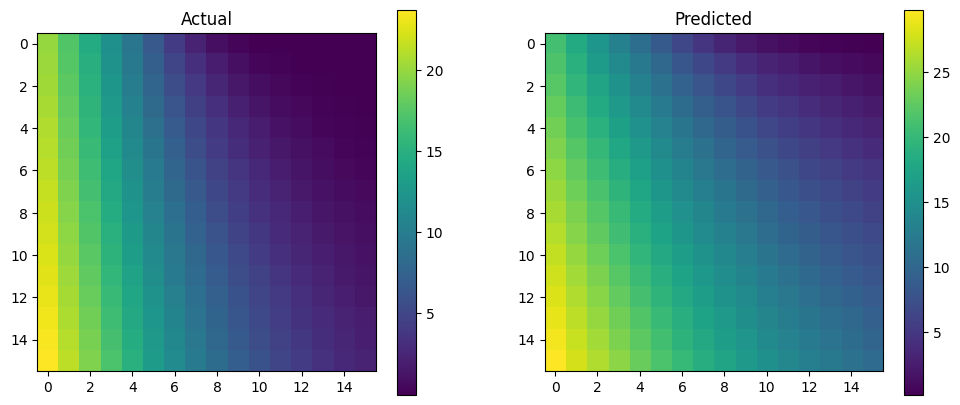

In [44]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.imshow(y_true[0, 0], cmap='viridis')
plt.title("Actual")
plt.colorbar()

plt.subplot(1, 2, 2)
plt.imshow(preds[0, 0], cmap='viridis')
plt.title("Predicted")
plt.colorbar()

plt.show()

#Heston Training and Evaluation

In [47]:
epochs = 30
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for xb, yb in train_heston_loader:
        xb, yb = xb.to(device), yb.to(device)
        preds = model(xb)
        loss = loss_fn(preds, yb.permute(0, 3, 1, 2))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1:02d} - Loss: {total_loss / len(train_heston_loader):.6f}")

Epoch 01 - Loss: 10.862368
Epoch 02 - Loss: 11.028166
Epoch 03 - Loss: 11.286875
Epoch 04 - Loss: 11.200305
Epoch 05 - Loss: 10.872665
Epoch 06 - Loss: 10.928853
Epoch 07 - Loss: 11.204777
Epoch 08 - Loss: 10.954667
Epoch 09 - Loss: 10.857118
Epoch 10 - Loss: 10.829448
Epoch 11 - Loss: 10.690514
Epoch 12 - Loss: 11.260353
Epoch 13 - Loss: 11.049462
Epoch 14 - Loss: 10.663733
Epoch 15 - Loss: 10.833478
Epoch 16 - Loss: 11.139474
Epoch 17 - Loss: 10.484746
Epoch 18 - Loss: 11.138342
Epoch 19 - Loss: 11.715244
Epoch 20 - Loss: 12.093913
Epoch 21 - Loss: 11.515903
Epoch 22 - Loss: 11.058576
Epoch 23 - Loss: 11.009833
Epoch 24 - Loss: 10.906581
Epoch 25 - Loss: 11.787651
Epoch 26 - Loss: 10.697756
Epoch 27 - Loss: 11.090092
Epoch 28 - Loss: 10.814752
Epoch 29 - Loss: 11.540099
Epoch 30 - Loss: 11.402537


In [48]:
model.eval()
with torch.no_grad():
    X_heston_test = X_heston_test.to(device)
    y_heston_test = y_heston_test.to(device)
    preds = model(X_heston_test).cpu().numpy()
    y_true = y_heston_test.cpu().numpy().transpose(0, 3, 1, 2)

y_true_flat = y_true.flatten()
preds_flat = preds.flatten()

mse = mean_squared_error(y_true_flat, preds_flat)
mae = mean_absolute_error(y_true_flat, preds_flat)
rmse = np.sqrt(mse)
r2 = r2_score(y_true_flat, preds_flat)

print(f"\n Evaluation Metrics:")
print(f"MSE  = {mse:.6f}")
print(f"MAE  = {mae:.6f}")
print(f"RMSE = {rmse:.6f}")
print(f"R²   = {r2:.4f}")


 Evaluation Metrics:
MSE  = 11.378022
MAE  = 2.648378
RMSE = 3.373132
R²   = 0.7894


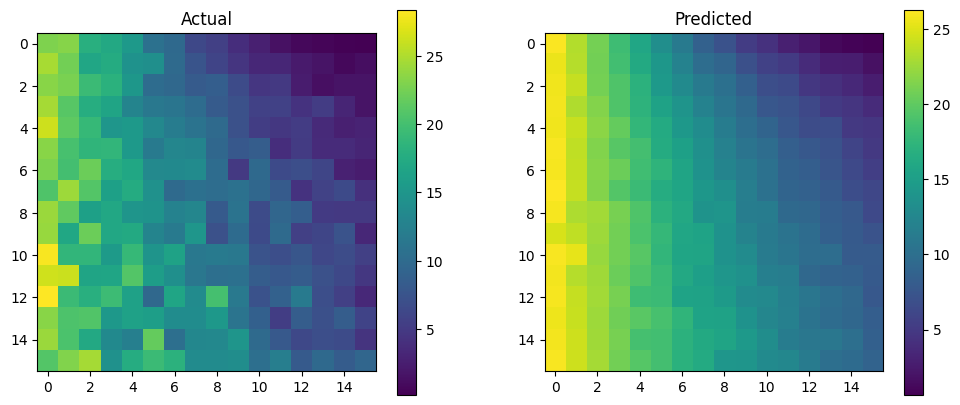

In [49]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.imshow(y_true[0, 0], cmap='viridis')
plt.title("Actual")
plt.colorbar()

plt.subplot(1, 2, 2)
plt.imshow(preds[0, 0], cmap='viridis')
plt.title("Predicted")
plt.colorbar()

plt.show()

#Conclusion
The Model work better on Black Scholes data than on the Heston Model accurately the reasons for which can be:

*   The generation of training set for Heston model is time consuming and very computationally heavy, so by reducing the number of paths and time divisions the data is very noisy hence is unable to give good results.

*   This model works very well for smooth equations, but for these it is unable to accurately capture the randomness.